# VAE outlier detection
Based on VAE outlier detection on CIFAR10, then modified for the SMIRK-use case

Link: https://docs.seldon.io/projects/alibi-detect/en/latest/examples/od_vae_cifar10.html 



In [2]:
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

In [3]:
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load data

In [4]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

170508288/170498071 [==============================] - 8s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Load or define the outlier detector (VAE)

In [16]:
load_outlier_detector = True
training_epochs = 1

In [17]:
filepath = 'my_path'  # change to directory where model is downloaded
detector_type = 'outlier'
dataset = 'cifar10'
detector_name = 'OutlierVAE'

'''
# Code below used to fetch a pre-trained one. Doesnt work. Code changed to load in from self-trained version.
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
'''
if load_outlier_detector:  # load pretrained outlier detector
    od = od = load_detector(filepath=os.path.join(filepath, detector_name))
else:  # define model, initialize, train and save outlier detector
    latent_dim = 1024

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])

    # initialize outlier detector
    od = OutlierVAE(threshold=.015,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=2)
    # train
    od.fit(X_train,
           loss_fn=elbo,
           cov_elbo=dict(sim=.05),
           epochs=training_epochs,
           verbose=True)

    # save the trained outlier detector
    save_detector(od, filepath)
    print('Saving the Outlier detector at: ', filepath)

## Showcase the reconstruction image: 

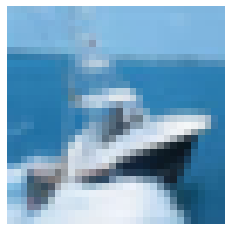

In [20]:
idx = 8
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()

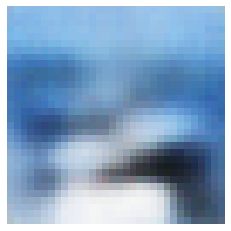

In [21]:
plt.imshow(X_recon.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.show()

In [22]:
X = X_train[:500]
print(X.shape)

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))

(500, 32, 32, 3)
['instance_score', 'feature_score', 'is_outlier']


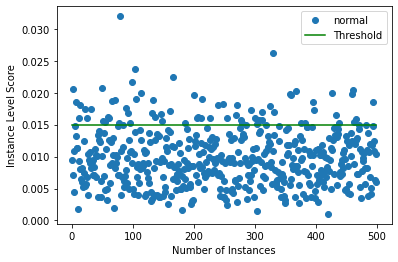

In [23]:
target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

In [35]:
od_preds['data'].keys()

dict_keys(['instance_score', 'feature_score', 'is_outlier'])

In [43]:
np.unique(od_preds['data']['is_outlier'])

array([0, 1])

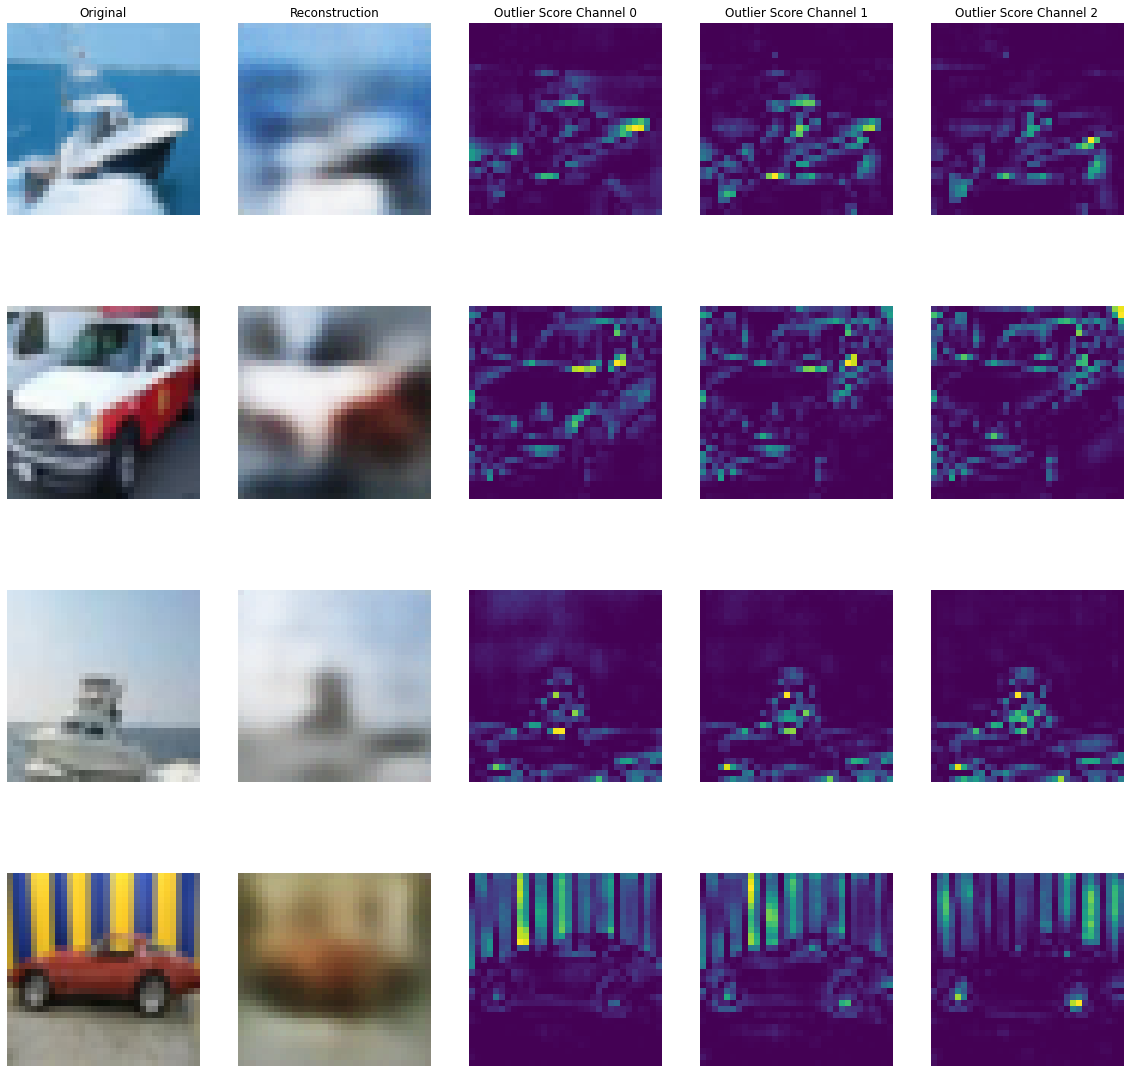

In [44]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[8, 60, 100, 330],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

In [45]:
# nb of predictions per image: n_masks * n_mask_sizes
n_mask_sizes = 10
n_masks = 20
n_imgs = 50

In [46]:
mask_sizes = [(2*n,2*n) for n in range(1,n_mask_sizes+1)]
print(mask_sizes)
img_ids = np.arange(n_imgs)
X_orig = X[img_ids].reshape(img_ids.shape[0], 32, 32, 3)
print(X_orig.shape)

[(2, 2), (4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14), (16, 16), (18, 18), (20, 20)]
(50, 32, 32, 3)


In [47]:
all_img_scores = []
for i in tqdm(range(X_orig.shape[0])):
    img_scores = np.zeros((len(mask_sizes),))
    for j, mask_size in enumerate(mask_sizes):
        # create masked instances
        X_mask, mask = apply_mask(X_orig[i].reshape(1, 32, 32, 3),
                                  mask_size=mask_size,
                                  n_masks=n_masks,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
        # predict outliers
        od_preds_mask = od.predict(X_mask)
        score = od_preds_mask['data']['instance_score']
        # store average score over `n_masks` for a given mask size
        img_scores[j] = np.mean(score)
    all_img_scores.append(img_scores)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


In [48]:
x_plt = [mask[0] for mask in mask_sizes]

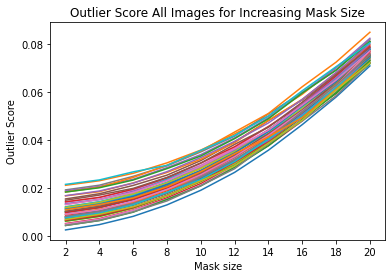

In [49]:
for ais in all_img_scores:
    plt.plot(x_plt, ais)
    plt.xticks(x_plt)
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier Score')
plt.show()

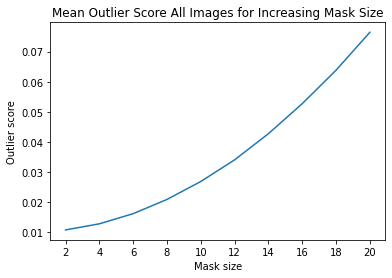

In [50]:
ais_np = np.zeros((len(all_img_scores), all_img_scores[0].shape[0]))
for i, ais in enumerate(all_img_scores):
    ais_np[i, :] = ais
ais_mean = np.mean(ais_np, axis=0)
plt.title('Mean Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.plot(x_plt, ais_mean)
plt.xticks(x_plt)
plt.show()

In [51]:
i = 8  # index of instance to look at

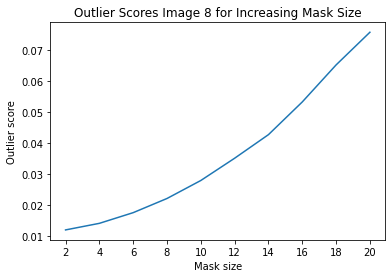

In [52]:
plt.plot(x_plt, all_img_scores[i])
plt.xticks(x_plt)
plt.title('Outlier Scores Image {} for Increasing Mask Size'.format(i))
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.show()

In [53]:
all_X_mask = []
X_i = X_orig[i].reshape(1, 32, 32, 3)
all_X_mask.append(X_i)
# apply masks
for j, mask_size in enumerate(mask_sizes):
    # create masked instances
    X_mask, mask = apply_mask(X_i,
                              mask_size=mask_size,
                              n_masks=1,  # just 1 for visualization purposes
                              channels=[0,1,2],
                              mask_type='normal',
                              noise_distr=(0,1),
                              clip_rng=(0,1))
    all_X_mask.append(X_mask)
all_X_mask = np.concatenate(all_X_mask, axis=0)
all_X_recon = od.vae(all_X_mask).numpy()
od_preds = od.predict(all_X_mask)

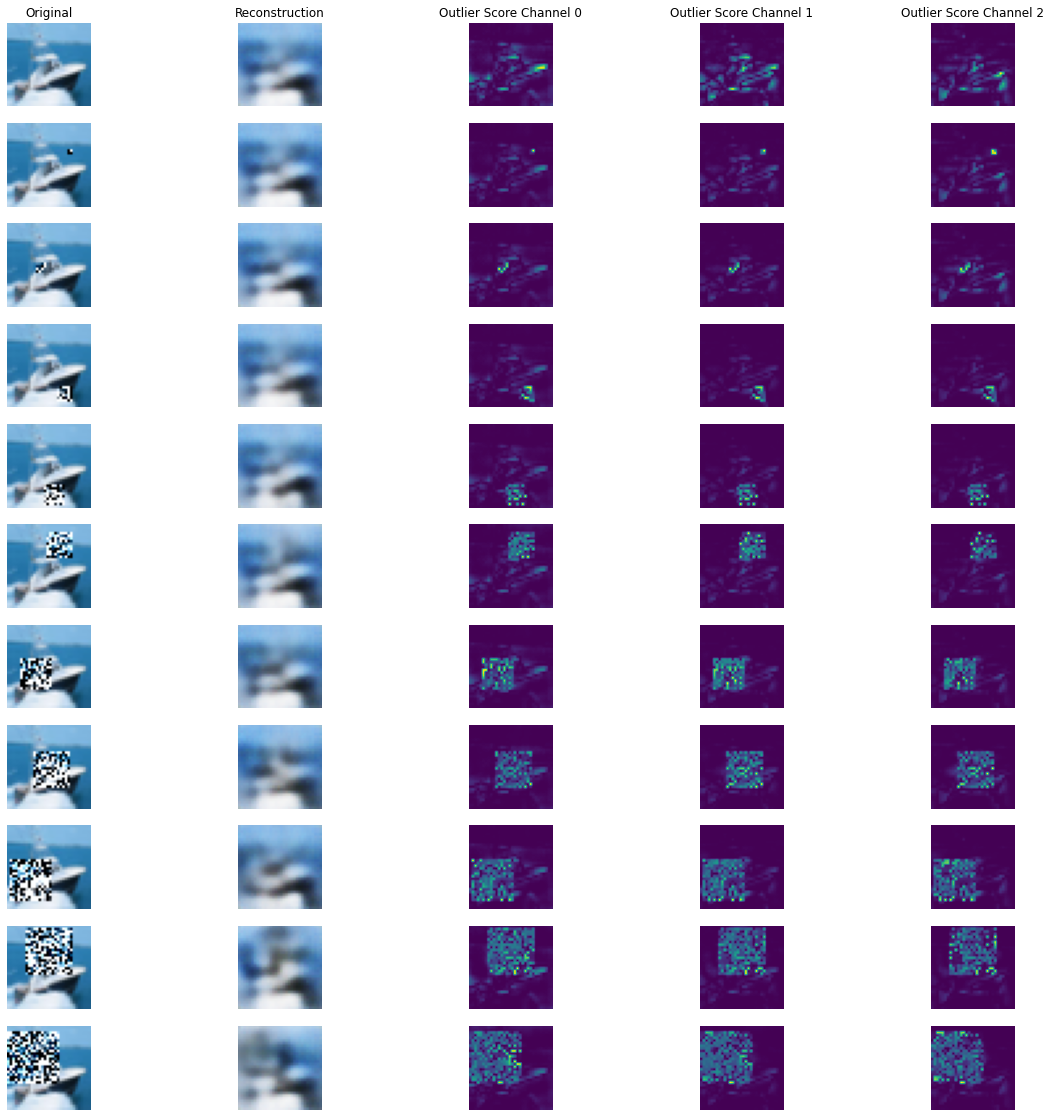

In [54]:
plot_feature_outlier_image(od_preds,
                           all_X_mask,
                           X_recon=all_X_recon,
                           max_instances=all_X_mask.shape[0],
                           n_channels=3)

In [55]:
perc_list = [20, 40, 60, 80, 100]

all_perc_scores = []
for perc in perc_list:
    od_preds_perc = od.predict(all_X_mask, outlier_perc=perc)
    iscore = od_preds_perc['data']['instance_score']
    all_perc_scores.append(iscore)

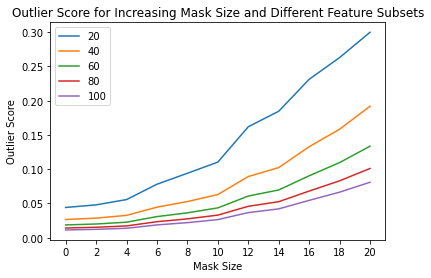

In [56]:
x_plt = [0] + x_plt
for aps in all_perc_scores:
    plt.plot(x_plt, aps)
    plt.xticks(x_plt)
plt.legend(perc_list)
plt.title('Outlier Score for Increasing Mask Size and Different Feature Subsets')
plt.xlabel('Mask Size')
plt.ylabel('Outlier Score')
plt.show()

In [57]:
print('Current threshold: {}'.format(od.threshold))
od.infer_threshold(X, threshold_perc=99)  # assume 1% of the training data are outliers
print('New threshold: {}'.format(od.threshold))

Current threshold: 0.015
New threshold: 0.020659624077379694
